In [54]:
from Bio.PDB import PDBParser
import time
import scipy
import time
import scipy.spatial
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt



In [55]:
'''Supplementary functions'''

def extract_pdb_info(pdb_file_path):
    """
    Reads a PDB file and extracts 3D spatial coordinates and amino acids.

    Input: pdb_file_path (str): Path to the PDB file.

    Output:  A list of dictionaries, each containing information about each atom.
    """
    # Create a PDBParser object
    parser = PDBParser(PERMISSIVE=1)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure('protein', pdb_file_path)
    
    # List to hold the extracted information
    atom_info_list = []

    # Extract information from the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        'model_id': model.id,
                        'chain_id': chain.id,
                        'residue_name': residue.resname,
                        'residue_id': residue.id[1],
                        'atom_name': atom.name,
                        'atom_coords': atom.coord.tolist()
                    }
                    atom_info_list.append(atom_info)

    return atom_info_list

def find_nearest_neighbors(data, angstrom):
    """
    Find the n-neighbors closest to the 'CA' atoms in the data using brute force with Euclidean distance.

    Parameters:
    - data: list of dictionaries, each containing atom information
    - angstrom: float, distance threshold for neighbor counting

    Returns:
    - data: list of dictionaries, containing only 'CA' atoms with updated 'neighbour_count' field,
      and without 'model_id', 'atom_name', and 'atom_coords' keys.
    """
    start_time = time.time()

    # Filter data to only include 'CA' atoms in chain_id 'A'
    ca_atoms = [atom for atom in data if atom.get('chain_id') == 'A' and atom['atom_name'] == 'CA']
    ca_coords = np.array([atom['atom_coords'] for atom in ca_atoms])

    # Calculate distances between 'CA' atoms
    distances = scipy.spatial.distance.cdist(ca_coords, ca_coords, 'euclidean')

    # Use 'residue_id' for DataFrame indexing
    residue_ids = [atom.get('residue_id', f"residue_{i}") for i, atom in enumerate(ca_atoms)]
    
    # Convert distance matrix to pandas DataFrame
    distance_df = pd.DataFrame(distances, index=residue_ids, columns=residue_ids)

    # Format distance matrix to 3 decimal places
    distance_df = distance_df.round(3)

    # Print the distance matrix
    print("Distance matrix between CA atoms (formatted to 3 decimal places):")
    print(distance_df)

    # Count neighbors within a distance of 'angstrom' units for each 'CA' atom
    for index, ca_point in enumerate(ca_coords):
        neighbour_count = np.sum((distances[index] <= angstrom) & (distances[index] != 0))
        ca_atoms[index]['neighbour_count'] = neighbour_count

    # Remove specified keys from the 'CA' atoms
    keys_to_remove = ['model_id', 'atom_name', 'atom_coords']
    for atom in ca_atoms:
        for key in keys_to_remove:
            atom.pop(key, None)

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")

    return ca_atoms

def extract_conservation_score(filename):
    result = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                # Skip header lines and lines below confidence cut-off
                if re.match(r'\s*\d+', line):
                    columns = line.split()
                    pos = int(columns[0])
                    score = float(columns[3])

                    # Check if there is a 3LATOM value, otherwise continue
                    if len(columns) > 6 and ':' in columns[2]:
                        residue_id = re.findall(r'\d+', columns[2])[0]  # Extract numbers from the string
                        residue_id = int(residue_id)  # Convert extracted string to integer
                        residue_name = re.findall(r'[A-Za-z]+', columns[2])[0]  # Extract letters from the string
                        result.append({'residue_id': residue_id, 'residue_name': residue_name, 'conservation_score': score})

        return result
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None

def merge_residue_data(conservation_scores, neighbour_counts):
    # Create a dictionary to index the neighbour_counts by residue_id and residue_name
    neighbour_dict = {(item['residue_id'], item['residue_name']): item for item in neighbour_counts}
    
    # List to hold merged data
    merged_data = []
    
    # Merge data from conservation_scores with neighbour_counts
    for score_entry in conservation_scores:
        residue_id = score_entry['residue_id']
        residue_name = score_entry['residue_name']
        
        # Find the corresponding entry in neighbour_counts
        neighbour_entry = neighbour_dict.get((residue_id, residue_name))
        
        if neighbour_entry:
            # Merge the two entries
            merged_entry = {
                'residue_id': residue_id,
                'residue_name': residue_name,
                'conservation_score': score_entry['conservation_score'],
                'neighbour_count': neighbour_entry['neighbour_count']
            }
            merged_data.append(merged_entry)
    
    return merged_data

def plot_and_calculate_correlation(data, title, num_residues=450):
    # Extract data for plotting
    residue_ids = [entry['residue_id'] for entry in data]
    neighbour_counts = [entry['neighbour_count'] for entry in data]
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot neighbour counts
    plt.scatter(residue_ids, neighbour_counts, color='green', label='Neighbour Count')
    
    # Check and plot conservation scores if available
    conservation_scores = [entry['conservation_score'] for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
    if conservation_scores:
        valid_entries = [entry for entry in data if 'conservation_score' in entry and entry['conservation_score'] is not None]
        valid_residue_ids = [entry['residue_id'] for entry in valid_entries]
        valid_neighbour_counts = [entry['neighbour_count'] for entry in valid_entries]
        
        plt.scatter(valid_residue_ids, conservation_scores, color='blue', label='Conservation Score')
        
        # Calculate and print the correlation
        if len(valid_residue_ids) == len(conservation_scores):
            correlation = np.corrcoef(conservation_scores, valid_neighbour_counts)[0, 1]
            print(f"Correlation between Conservation Score and Neighbour Count: {correlation}")
        else:
            print("Mismatch in lengths of valid_residue_ids and conservation_scores")
    else:
        print("Conservation scores not found. Plotting only Neighbour Count.")

    plt.xlabel('Residue ID')
    plt.ylabel('Score / Count')
    plt.title(f'{title}: Residue ID vs Conservation Score and Neighbour Count (5A)')
    plt.legend()
    
    # Set plot limits for residue IDs
    plt.xlim(0, num_residues)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [60]:
import asyncio
import os
import re
from playwright.async_api import async_playwright

def download_conservation_scores(pdb_file_path, chains):
    pattern = r'pdb(\w+)\.pdb'
    pdb_ids = [match.group(1).upper() for file_path in pdb_file_path if (match := re.search(pattern, file_path))]
    print(pdb_ids)
    
    # Ensure the directory for saving files exists
    output_dir = "conservation_scores"
    os.makedirs(output_dir, exist_ok=True)

    async def scrape_consurf(pdb_id, chain):
        url = f"https://consurfdb.tau.ac.il/DB/{pdb_id.upper()}{chain}/{pdb_id.upper()}{chain}_consurf_summary.txt"
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page()
            try:
                await page.goto(url, timeout=60000)  # Increase timeout to 60 seconds
                content = await page.content()  # Get the content of the page
                if "Page not found" in content:
                    print(f"Error: Page not found for {pdb_id} chain {chain}")
                    return None
                else:
                    content = await page.text_content("body")  # Get the text content directly from the body
                    if content and "Page not found" not in content:
                        file_path = f"{output_dir}/{pdb_id}_consurf_summary.txt"
                        with open(file_path, "w") as file:
                            file.write(content)
                        print(f"Summary for {pdb_id} chain {chain} saved successfully at {file_path}.")
                        return content
                    else:
                        print(f"Content for {pdb_id} chain {chain} not found or invalid.")
                        return None
            except Exception as e:
                print(f"Error processing {pdb_id} chain {chain}: {e}")
                return None
            finally:
                await browser.close()

    async def main():
        tasks = []
        for pdb_id in pdb_ids:
            for chain in chains:
                tasks.append(scrape_consurf(pdb_id, chain))
        
        # Run all tasks concurrently and gather their results
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        for pdb_id, result in zip(pdb_ids, results):
            if isinstance(result, Exception):
                print(f"Error processing {pdb_id}: {result}")
            elif result:
                print(f"Summary for {pdb_id} saved successfully.")
            else:
                print(f"No content saved for {pdb_id}.")

    # Helper function to run the asyncio code in the correct context
    def run_async_code():
        try:
            loop = asyncio.get_running_loop()
            if loop.is_running():
                return loop.create_task(main())
        except RuntimeError:
            return asyncio.run(main())

    run_async_code()

In [56]:
'''Main function'''

def pdb_to_n_neighbour_vector(pdb_file_path, angstrom):
    
    amino_vector = []
    title = pdb_file_path.split('/')[-1].split('.')[0][3:].upper()

    atom_info_list = extract_pdb_info(pdb_file_path)

    amino_acid_info_count = find_nearest_neighbors(atom_info_list, angstrom)

    print(f"Number of Amino Acids: {len(amino_acid_info_count)}")
    conservation_scores = extract_conservation_score(filename=f"HYAL1_conservation_scores/{title}_consurf_summary.txt")
    print(conservation_scores)

    if conservation_scores is not None:
        merged_residues = merge_residue_data(conservation_scores, amino_acid_info_count)
        print(merged_residues)
        plot_and_calculate_correlation(merged_residues, title)
    else:
        print("Conservation scores not found, skipping merge_residue_data. Going straight to plotting.")
        merged_residues = amino_acid_info_count
        plot_and_calculate_correlation(merged_residues, title)

    return merged_residues

def merge_to_ref_seq(ref_seq, completed):
    # Convert ref_seq to dictionary for efficient lookup
    ref_seq_dict = {entry['residue_id']: entry for entry in ref_seq}

    for entry in completed:
        residue_id = entry['residue_id']
        if residue_id in ref_seq_dict:
            ref_seq_entry = ref_seq_dict[residue_id]
            if 'neighbour_count' in entry:
                ref_seq_entry['neighbour_count'] = entry['neighbour_count']
            if 'conservation_score' in entry:
                ref_seq_entry['conservation_score'] = entry['conservation_score']
        else:
            ref_seq_dict[residue_id] = {
                'residue_id': residue_id,
                'residue_name': entry['residue_name'],
                'neighbour_count': entry.get('neighbour_count', 0),
                'conservation_score': entry.get('conservation_score')
            }

    # Convert back to list
    updated_ref_seq = list(ref_seq_dict.values())
    return updated_ref_seq



In [58]:
pdb_file_path = ['./HYAL1_pdb/pdb2pe4.pdb']

download_conservation_scores(pdb_file_path, chains = ['A'])

['2PE4']


Summary for 2PE4 chain A saved successfully at conservation_scores/2PE4_consurf_summary.txt.
Summary for 2PE4 saved successfully.


Distance matrix between CA atoms (formatted to 3 decimal places):
        1       2       3       4       5       6       7       8       9    \
1     0.000   3.821   6.662   9.708  11.863  14.258  16.904  18.432  19.977   
2     3.821   0.000   3.841   7.196   8.734  10.840  13.882  15.407  16.542   
3     6.662   3.841   0.000   3.912   6.411   7.877  10.491  12.556  13.998   
4     9.708   7.196   3.912   0.000   3.896   5.712   7.339   9.163  11.316   
5    11.863   8.734   6.411   3.896   0.000   3.876   6.284   6.746   8.272   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
431  46.531  42.748  40.533  39.185  36.734  33.512  33.062  32.751  29.422   
432  43.202  39.427  37.111  35.618  33.165  29.947  29.368  29.013  25.741   
433  41.822  38.019  35.865  34.274  31.520  28.570  28.117  27.325  23.924   
434  39.022  35.204  33.288  31.941  29.082  26.238  26.231  25.451  21.841   
435  36.302  32.502  30.410  28.786  25.903  23.089  22.816  21.8

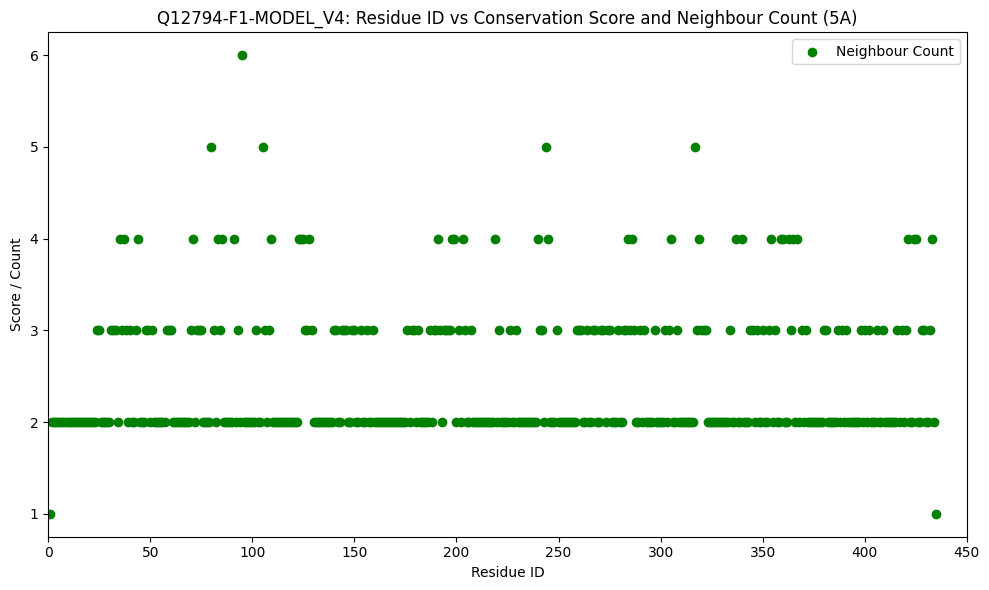

/home/codespace/.python/current/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3868.
  warnings.warn(


Distance matrix between CA atoms (formatted to 3 decimal places):
        20      21      22      23      24      25      26      27      28   \
20    0.000   3.894   6.633   9.847  12.580  15.582  15.550  19.016  20.762   
21    3.894   0.000   3.846   6.178   9.093  11.839  11.657  15.151  17.024   
22    6.633   3.846   0.000   3.884   6.605   9.933  10.372  13.328  14.512   
23    9.847   6.178   3.884   0.000   3.825   6.397   6.527   9.472  10.926   
24   12.580   9.093   6.605   3.825   0.000   3.779   6.145   8.387   8.872   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
432  17.364  16.392  13.387  14.470  12.785  15.669  18.729  19.805  18.148   
433  15.439  15.208  12.844  14.755  13.646  16.915  19.776  21.477  20.385   
434  16.194  16.809  14.816  17.354  16.828  20.291  22.888  24.749  23.803   
435  13.873  14.861  12.969  15.985  16.277  19.964  22.027  24.069  23.496   
436  13.885  14.006  11.310  13.835  14.018  17.605  19.611  21.2

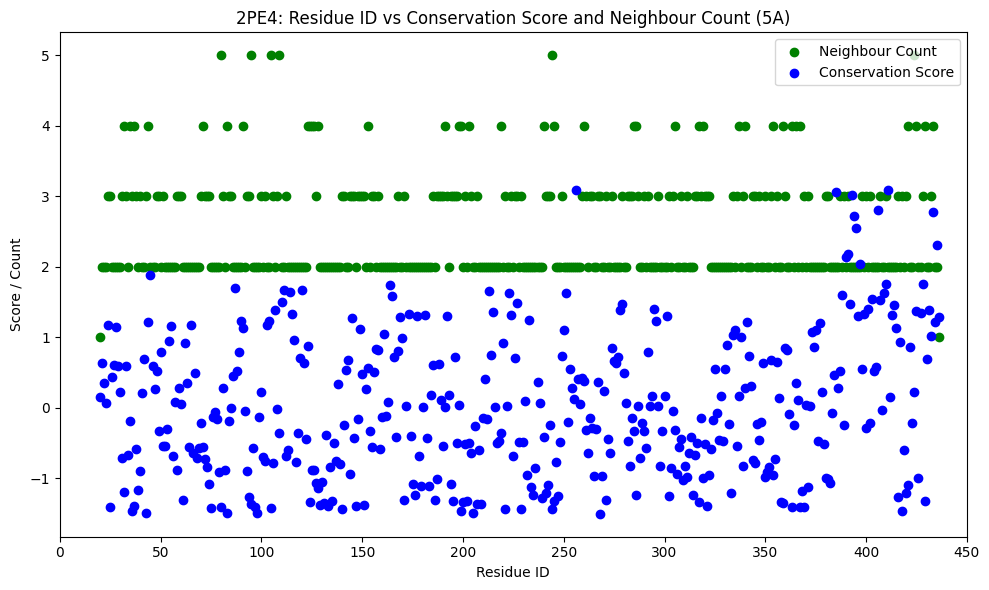

In [61]:
ref_seq = './HYAL1_pdb/AF-Q12794-F1-model_v4.pdb'
ref_seq = pdb_to_n_neighbour_vector(ref_seq, angstrom = 5)

for pdb_file in pdb_file_path:
        
        completed = pdb_to_n_neighbour_vector(pdb_file, angstrom = 5)
        updated_ref_seq = merge_to_ref_seq(ref_seq, completed)

[{'chain_id': 'A', 'residue_name': 'MET', 'residue_id': 1, 'neighbour_count': 1}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 2, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 3, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'HIS', 'residue_id': 4, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 5, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 6, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'PRO', 'residue_id': 7, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ILE', 'residue_id': 8, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'CYS', 'residue_id': 9, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'ALA', 'residue_id': 10, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'LEU', 'residue_id': 11, 'neighbour_count': 2}, {'chain_id': 'A', 'residue_name': 'PHE', 'residue_id': 12, 'neighbour_count': 2}, {'chain_id': 'A', 'resid

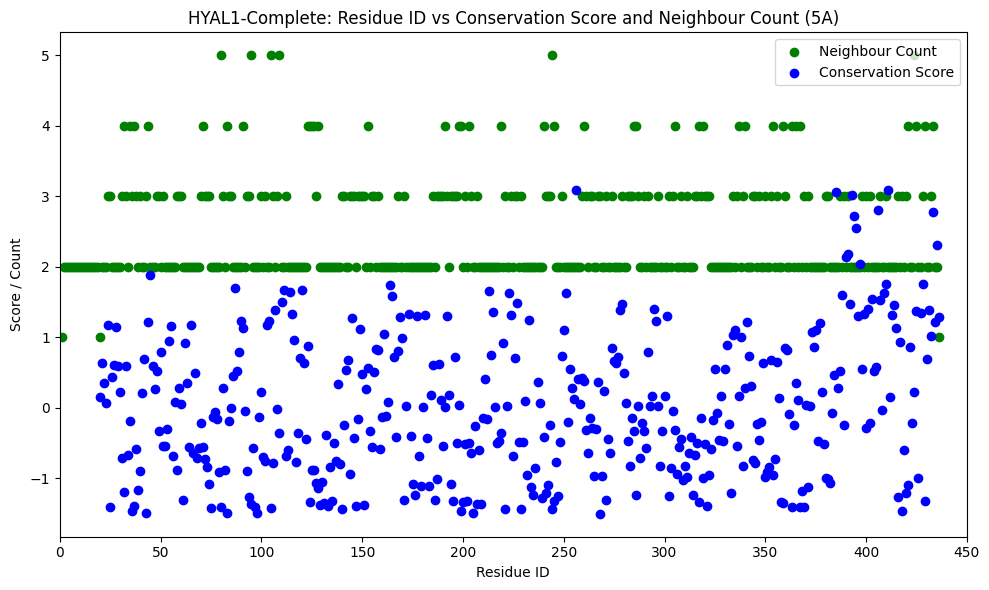

In [62]:
print(updated_ref_seq)
plot_and_calculate_correlation(updated_ref_seq, title='HYAL1-Complete')